[View in Colaboratory](https://colab.research.google.com/github/MarcinWylot/CryptocurrencyPricePredictor/blob/master/BitcoinPredictWithLSTM.ipynb)

https://github.com/curiousily/How-to-Predict-Bitcoin-Prices-using-LSTMs-in-Keras/blob/master/predicting_stock_prices.ipynb

https://github.com/SiaFahim/lstm-crypto-predictor/blob/master/lstm_crypto_price_prediction.ipynb

https://github.com/kmsravindra/ML-AI-experiments/blob/master/AI/LSTM-time_series/LSTM%20-%20Sine%20wave%20predictor.ipynb


https://github.com/Prakash2403

In [1]:
import requests
import json
import calendar
import random 
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from keras.layers.core import Dense, Activation, Dropout
from keras.layers.recurrent import LSTM
from keras.models import Sequential, load_model, save_model
from keras.callbacks import CSVLogger, ModelCheckpoint
import h5py
import os
import tensorflow as tf
from keras.backend.tensorflow_backend import set_session
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score, median_absolute_error, mean_absolute_error
import math 


Using TensorFlow backend.


In [2]:
url = 'https://min-api.cryptocompare.com/data/histohour?tsym=USD&limit=9999&fsym=BTC'
response = requests.get(url)

json_array = json.loads(response.text)

df = pd.DataFrame(json_array['Data'], columns = ['time', 'close', 'high', 'low', 'open', 'volumefrom','volumeto'])
df.drop('time', 1, inplace=True)
df.head()

,close,high,low,open,volumefrom,volumeto
0,9228.40,9250.40,9202.69,9246.26,2169.29,20020888.16
1,9209.22,9229.37,9182.41,9228.40,2260.36,20815829.65
2,9224.62,9232.55,9208.09,9209.31,1269.91,11726181.69
3,9206.59,9226.76,9183.10,9223.13,1627.23,14973610.22
4,9327.88,9344.15,9198.28,9204.65,5395.58,50124976.05


In [3]:
nb_features = df.shape[1]
df.shape

(2001, 6)

In [0]:
def load_data(X, seq_len, train_size=0.9):
    amount_of_features = X.shape[1]
    X_mat = X.as_matrix()
    sequence_length = seq_len + 1
    data = []
    
    for index in range(len(X_mat) - sequence_length):
        data.append(X_mat[index: index + sequence_length])
    
    data = np.array(data)
    train_split = int(round(train_size * data.shape[0]))
    train_data = data[:train_split, :]
    
    x_train = train_data[:, :-1]
    y_train = train_data[:, -1][:,0]
    
    x_test = data[train_split:, :-1] 
    y_test = data[train_split:, -1][:,0]

    return x_train, y_train, x_test, y_test

In [5]:
window = 5
X_train, y_train, X_test, y_test = load_data(df, window)

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)


#print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)
#print(df.head(20))
#print(y_train[:10])
#X_train[:10]

(1796, 5, 6) (199, 5, 6) (1796,) (199,)


In [6]:
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train.reshape(-1,X_train.shape[2]))
X_train_scaled = X_train_scaled.reshape(X_train.shape[0], X_train.shape[1], nb_features)

X_test_scaled = scaler.transform(X_test.reshape(-1,X_test.shape[2]))
X_test_scaled = X_test_scaled.reshape(X_test.shape[0], X_test.shape[1], nb_features)

print(X_train_scaled.shape, X_test_scaled.shape)



(1796, 5, 6) (199, 5, 6)


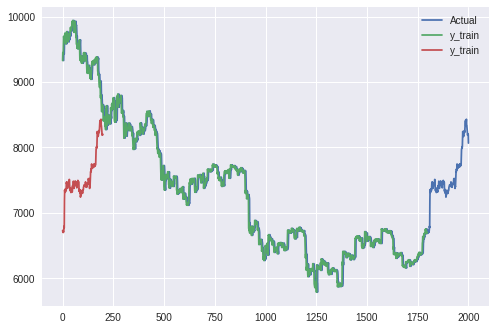

In [7]:
plt.plot(df.close[5:], label='Actual')
plt.plot(y_train, label='y_train')
plt.plot(y_test, label='y_train') #gotta take care on index
plt.legend(loc='best')
plt.show()

In [0]:
neurons = 512                 
activation_function = 'tanh' 
dropout = 0.25     
loss = 'mse'                  
optimizer="adam"              
            
batch_size = 12               
epochs = 50                                 
training_size = 0.8


def nn_model(input_shape=(window, nb_features), output_size=1, neurons=neurons, activ_func=activation_function, dropout=dropout, loss=loss, optimizer=optimizer):
  model = Sequential()
  
  model.add(LSTM(neurons, return_sequences=True, input_shape=(inputs.shape[1], inputs.shape[2]), activation=activ_func))
  model.add(Dropout(dropout))
  
  model.add(LSTM(neurons, return_sequences=False, activation=activ_func))
  model.add(Dropout(dropout))
  
  model.add(LSTM(neurons, activation=activ_func))
  model.add(Dropout(dropout))
  
  model.add(Dense(units=output_size))
  #model.add(Activation(activ_func))
  
  model.compile(loss=loss, optimizer=optimizer, metrics=['mse'])
#  model.summary()
  return model

def nn_model2(input_shape=(window, nb_features)):
    d = 0.2
    model = Sequential()
    
    model.add(LSTM(128, input_shape=input_shape, return_sequences=True))
    model.add(Dropout(d))
        
    model.add(LSTM(128, input_shape=input_shape, return_sequences=False))
    model.add(Dropout(d))
        
    model.add(Dense(32,kernel_initializer="uniform",activation='relu'))        
    model.add(Dense(1,kernel_initializer="uniform",activation='linear'))
    
    model.compile(loss='mse',optimizer='adam', metrics=['mse'])
    
#    model.summary()
    return model
  
# random seed for reproducibility
np.random.seed(32)
# initialise model architecture
model = nn_model2()

In [9]:
model.fit(X_train_scaled, y_train, batch_size=32, epochs=1000, verbose=0)

trainPredict = model.predict(X_train_scaled)
testPredict = model.predict(X_test_scaled)

trainScore = mean_squared_error(y_train, trainPredict[:,0]) ** .5
print('Train Score: %.2f RMSE' % (trainScore))
testScore = mean_squared_error(y_test, testPredict[:,0]) ** .5
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 78.95 RMSE
Test Score: 72.87 RMSE


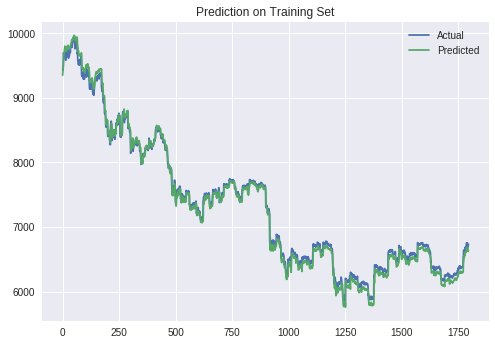

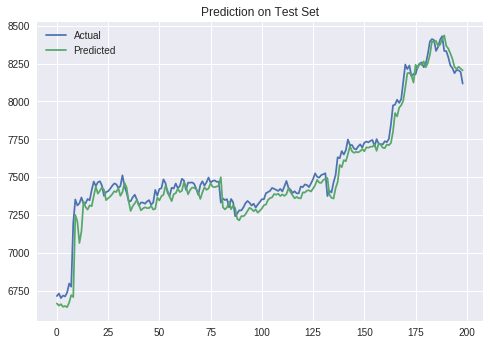

In [11]:
plt.plot(y_train, label='Actual')
plt.plot(trainPredict, label='Predicted')
plt.legend(loc='best')
plt.title('Prediction on Training Set')
plt.show()

plt.plot(y_test, label='Actual')
plt.plot(testPredict, label='Predicted')
plt.legend(loc='best')
plt.title('Prediction on Test Set')
plt.show()